In [0]:
!pip install concise

     |████████████████████████████████| 1.3MB 6.7MB/s 
     |████████████████████████████████| 317kB 40.8MB/s 
  Created wheel for gtfparse: filename=gtfparse-1.2.0-cp36-none-any.whl size=11883 sha256=8d340f5f99ebe352da10eef5b76b72d982bdbacb13f21baaec0c3674dbeaac03
  Stored in directory: /root/.cache/pip/wheels/c4/27/96/6ba6fe28cbb162c326823553e3e45ac502160d1340566360f8
Successfully built gtfparse
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive 


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [0]:
cd /gdrive/My\ Drive/nn 


/gdrive/My Drive/nn


In [0]:

%tensorflow_version 1.x
import argparse
import os
import pickle
import sys

import numpy as np

np.random.seed(7)  # for reproducibility

import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold

# tf.python.control_flow_ops = tf


from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.pooling import MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.python.keras.backend as K

import matplotlib as mpl

mpl.use('Agg')
# from keras.utils.layer_utils import print_layer_shapes

import utils
sys.path.append(".")
from utils import precision, recall, load_data_merged
import plotseqlogo
import IntegratedGradients
from plotseqlogo import *
from IntegratedGradients import *
from utils import *

from tensorflow.python.keras.backend import set_session


CLASS_PARTIAL_LOSS = 0
CLASS_COMPLETELY_LOSS = 1 

TensorFlow 1.x selected.


Using TensorFlow backend.
2020-05-03 17:51:11,193 [INFO] Generating grammar tables from /usr/lib/python3.6/lib2to3/Grammar.txt
2020-05-03 17:51:11,226 [INFO] Generating grammar tables from /usr/lib/python3.6/lib2to3/PatternGrammar.txt


2020-05-03 17:51:11,816 [WARNING] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/gdrive/My Drive/nn/plotseqlogo.py:34: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/gdrive/My Drive/nn/plotseqlogo.py:35: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)


In [0]:
x_train_seq, y_train, x_valid_seq, y_valid, x_test_seq, y_test = load_data_merged(r"dataset/classifier_data_ccpg1.pkl", 150, True)

In [0]:
predict_label =CLASS_COMPLETELY_LOSS
number_of_seq = 10

In [0]:
def get_refrence_list(seq_example):
    rf = np.zeros(seq_example.shape)
    m = int(seq_example.shape[0]/ 2 - 1)
    rf[m][1]=1
    rf[m+1][2] = 1
    return rf

In [44]:
sess = tf.Session()
K.set_session(sess)

session = K.get_session()
init = tf.global_variables_initializer()
session.run(init)

with session.as_default():
    with session:
      model = load_model("./models/150cpg.h5")
      pred = model.predict(x_test_seq)
      ind= []

      if predict_label ==CLASS_PARTIAL_LOSS:
         pred = 1 - pred

      for i in sorted(enumerate(pred), key=lambda x:x[1],reverse=True):
        if y_test[i[0]]==predict_label and pred[i[0]] > 0.50:
          ind.append(i[0])
      
      ind = ind[0:number_of_seq]
      
      rf = get_refrence_list(x_test_seq[0])

      gradients = integrated_gradients(model) 
      ex_seq=np.array([gradients.explain([x_test_seq[i]],reference=[rf])[0] for i in ind])

      if predict_label == CLASS_PARTIAL_LOSS:
        ex_seq = ex_seq * -1

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


Graphs for comletely loss (WCGW)


/gdrive/My Drive/nn/plotseqlogo.py:150: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])


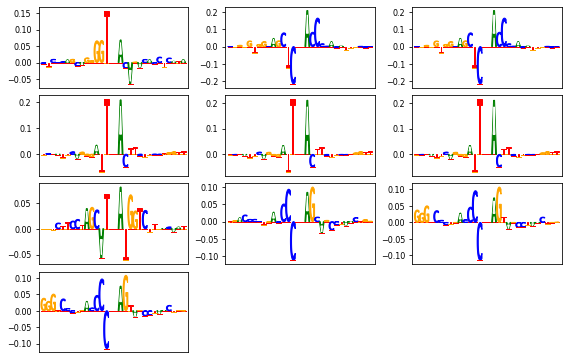

In [45]:
label = "partial lost (SCGS)" if predict_label == CLASS_PARTIAL_LOSS else "comletely loss (WCGW)"
print("Graphs for %s" % label)
ncol = 3
seqlogo_fig(np.transpose(ex_seq[:,60:90,:4],axes=(1,2,0)), vocab="DNA", figsize=(8,number_of_seq/ncol+2), ncol=ncol)

Graphs for comletely loss (WCGW) -- mean seq


/gdrive/My Drive/nn/plotseqlogo.py:150: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax.set_xticks([], [])


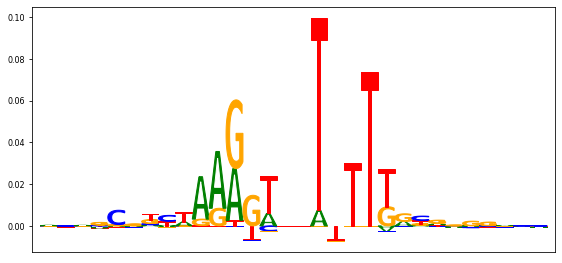

In [43]:
label = "partial lost (SCGS)" if predict_label == CLASS_PARTIAL_LOSS else "comletely loss (WCGW)"
print("Graphs for %s -- mean seq" % label)
seqlogo_fig(np.transpose(np.mean(ex_seq[:,60:90,:4],axis=0).reshape(1,30,4),axes=(1,2,0)), vocab="DNA", figsize=(8,4), ncol=1)